In [1]:
import pandas as pd
import requests
import sddk

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [2]:
# for exporting data to googlesheets/sciencedata
# (feel free to skip)

s = sddk.cloudSession("sciencedata.dk")
# establish connection with gogglesheets...
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict") # or load it from a local storage: json.load(open("../../ServiceAccountsKey.json", "r"))
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
paul_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1h4M-gK9TPIfeTV528tUuPBfZF1wtcNCA10yIlJYqGTE/edit?usp=sharing")

endpoint variable has been configured to: https://sciencedata.dk/files/


In [34]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

# LAGTec subcorpus preparation

In [3]:
# find local version of the input dataset
local_paths = !find ~/Projects -name "LIRE_v1-0.json"
print(local_paths)

['/Users/kasev/Projects/paul/data/large_files/LIRE_v1-0.json']


In [4]:
# LAGT (v1.0.1) dataset directly from Zenodo
try:
    LAGT = pd.read_json(local_paths[0])
except:
    resp = requests.get("https://zenodo.org/record/4971946/files/LAGT_v1-0.json?download=1")
    # save it for next time
    LAGT = pd.DataFrame(resp.json())
    LAGT.to_json("../data/large_files/LIRE_v1-0.json")

In [5]:
LAGT.columns

Index(['filename', 'author', 'title', 'wordcount', 'author_id', 'doc_id',
       'raw_date', 'date_avr', 'date_probs', 'date_manual', 'provenience',
       'tlg_epithet', 'clean_string', 'n_sentences', 'lemmatized_sentences'],
      dtype='object')

In [6]:
len(LAGT[LAGT["provenience"]=="christian"])

147

In [7]:
# upload manually updated metadata
LAGT_metadata = pd.read_csv("../data/LAGT_metadata.csv")
# update dates
# any work cosnidered to be dated between two centuries is dated to the latter
def update_dateavr(date_avr):
    if ".5" not in str(date_avr):
        date_avr += 0.5
    return date_avr
LAGT_metadata["date_avr"] = LAGT_metadata["date_avr"].apply(update_dateavr)

# update provenience
provenience_dict = dict(zip(LAGT_metadata["filename"],  LAGT_metadata["provenience"]))
LAGT["provenience"] = LAGT["filename"].apply(lambda x: provenience_dict[x])

# update author
author_dict = dict(zip(LAGT_metadata["filename"],  LAGT_metadata["author"]))
LAGT["author"] = LAGT["filename"].apply(lambda x: author_dict[x])

# update title
title_dict = dict(zip(LAGT_metadata["filename"],  LAGT_metadata["title"]))
LAGT["title"] = LAGT["filename"].apply(lambda x: title_dict[x])

In [8]:
len(LAGT[LAGT["provenience"]=="christian"])

213

In [9]:
# update dates
# any work cosnidered to be dated between two centuries is dated to the latter
def update_dateavr(date_avr):
    if ".5" not in str(date_avr):
        date_avr += 0.5
    return date_avr
LAGT["date_avr"] = LAGT["date_avr"].apply(update_dateavr)

In [10]:
# non-dated christian texts
LAGT[(LAGT["provenience"]=="christian") & (LAGT["date_avr"].isnull())]

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,tlg_epithet,clean_string,n_sentences,lemmatized_sentences
1194,tlg1750.tlg001.1st1K-grc1.xml,Pseudo-Dorotheus,De prophetarum vita et obitu (Dorothei recensio),5347,tlg1750,tlg1750.tlg001,Varia,NaN,{},NaN,christian,[],"Οὗτος Ὠσηὲ τῶν ιβʹ προφητῶν ὁ πρῶτος, ἀξιωθεὶς...",329,"[[ὠσηὲ, προφήτης, πρῶτος, ἀξιωθεὶς, λέγω, δεσπ..."
1195,tlg1750.tlg002.1st1K-grc1.xml,De prophetarum vita et obitu (recensio anonyma),De prophetarum vita et obitu (recensio anonyma),4110,tlg1750,tlg1750.tlg002,Varia,NaN,{},NaN,christian,[],αʹ. Ἡσαΐας ἀπὸ Ἱερουσαλὴμ θνήσκει ὑπὸ Μανασσῆ ...,329,"[[], [Ἠσαΐας, Ἱεροσόλυμα, θνήσκω, Μανασσῆς, πρ..."
1196,tlg1750.tlg003.1st1K-grc1.xml,De prophetarum vita et obitu (recensio scholii...,De prophetarum vita et obitu (recensio scholii...,1166,tlg1750,tlg1750.tlg003,Varia,NaN,{},NaN,christian,[],αʹ. Ὠσηὲ ἑρμηνεύεται σωζόμενος. Οὗτος ἦν ἐκ ελ...,105,"[[], [ὠσηὲ, ἑρμηνεύω, σωζόμενος], [ελεμὼθ, φυλ..."
1197,tlg1750.tlg004.1st1K-grc1.xml,Pseudo-Dorotheus,Index apostolorum discipulorumque Domini,3616,tlg1750,tlg1750.tlg004,Varia,NaN,{},NaN,christian,[],Δωροθέου ἐπισκόπου Τύρου ἀρχαίου ἀνδρὸς πνευμα...,253,"[[δωροθέου, ἐπίσκοπος, Τύρος, ἀρχαῖος, ἀνήρ, π..."


In [11]:
(LAGT["date_avr"] < 5).sum()

1277

In [12]:
for date in [0.5, 1.5, 2.5, 3.5, 4.5]:
    mask = ((LAGT["date_avr"] <= date) & (LAGT["provenience"]=="christian"))
    print(date,
          mask.sum(),
          LAGT[mask]["wordcount"].sum()
          )

0.5 29 151723
1.5 51 474124
2.5 104 1711991
3.5 137 3059696
4.5 148 3566823


In [13]:
# all texts before the end of the
LAGTec = LAGT[(LAGT["date_avr"] < 5) & (LAGT["provenience"]=="christian")].copy()

"Acts of Paul and Thecla"
- http://www.patrologia-lib.ru/apocryph/novum/a_paul.htm

In [14]:
# to safe your ram memory:
# del LAGT

In [15]:
LAGTec[LAGTec["author_id"].str.startswith("tlg0031paul")]

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,tlg_epithet,clean_string,n_sentences,lemmatized_sentences
390,tlg0031.tlg006.perseus-grc2.xml,Paul of Tarsus,Romans,7107,tlg0031paul,tlg0031.tlg006,A.D. 1,0.5,{'0.5': 1},0.5,christian,[],"ΠΑΥΛΟΣ δοῦλος Ἰησοῦ Χριστοῦ, κλητὸς ἀπόστολος...",490,"[[Παῦλος, δοῦλος, Ἰησοῦς, Χριστός, κλητός, ἀπό..."
391,tlg0031.tlg007.perseus-grc2.xml,Paul of Tarsus,1 Corinthians,6814,tlg0031paul,tlg0031.tlg007,A.D. 1,0.5,{'0.5': 1},0.5,christian,[],ΠΑΥΛΟΣ κλητὸς ἀπόστολος Ἰησοῦ Χριστοῦ διὰ θελ...,544,"[[Παῦλος, κλητός, ἀπόστολος, Ἰησοῦς, Χριστός, ..."
392,tlg0031.tlg008.perseus-grc2.xml,Paul of Tarsus,2 Corinthians,4470,tlg0031paul,tlg0031.tlg008,A.D. 1,0.5,{'0.5': 1},0.5,christian,[],ΠΑΥΛΟΣ ἀπόστολος Χριστοῦ Ἰησοῦ διὰ θελήματος ...,274,"[[Παῦλος, ἀπόστολος, Χριστός, Ἰησοῦς, θέλημα, ..."
393,tlg0031.tlg009.perseus-grc2.xml,Paul of Tarsus,Galatians,2235,tlg0031paul,tlg0031.tlg009,A.D. 1,0.5,{'0.5': 1},0.5,christian,[],"ΠΑΥΛΟΣ ἀπόστολος, οὐκ ἀπʼ ἀνθρώπων οὐδὲ διʼ ἀ...",159,"[[Παῦλος, ἀπόστολος, ἄνθρωπος, ἄνθρωπος, Ἰησοῦ..."
395,tlg0031.tlg011.perseus-grc2.xml,Paul of Tarsus,Philippians,1631,tlg0031paul,tlg0031.tlg011,A.D. 1,0.5,{'0.5': 1},0.5,christian,[],ΠΑΥΛΟΣ ΚΑΙ ΤΙΜΟΘΕΟΣ δοῦλοι Χριστοῦ Ἰησοῦ πᾶσι...,83,"[[Παῦλος, Τιμόθεος, δοῦλος, Χριστός, Ἰησοῦς, ἅ..."
397,tlg0031.tlg013.perseus-grc2.xml,Paul of Tarsus,1 Thessalonians,1475,tlg0031paul,tlg0031.tlg013,A.D. 1,0.5,{'0.5': 1},0.5,christian,[],ΠΑΥΛΟΣ ΚΑΙ ΣΙΛΟΥΑΝΟΣ ΚΑΙ ΤΙΜΟΘΕΟΣ τῇ ἐκκλησίᾳ...,65,"[[Παῦλος, σιλουανος, Τιμόθεος, ἐκκλησία, Θεσσα..."
402,tlg0031.tlg018.perseus-grc2.xml,Paul of Tarsus,Philemon,334,tlg0031paul,tlg0031.tlg018,A.D. 1,0.5,{'0.5': 1},0.5,christian,[],ΠΑΥΛΟΣ δέσμιος Χριστοῦ Ἰησοῦ καὶ Τιμόθεος ὁ ἀ...,17,"[[Παῦλος, δέσμιος, Χριστός, Ἰησοῦς, Τιμόθεος, ..."


# Additional cleaning of texts

In [16]:
# unfortunately we do not have The Martrdom of Perpetua and Felicita
print(LAGTec[LAGTec["author_id"]=="tlg2016"]["clean_string"].tolist()[0])

 , , , ; ? , . : , . , , , : : , . , , , ; , : , , . , : , , , . , , . , , , , , : . , . , , , : , , , , , ? : . : , ? : . , , . , : , . , , . : , . : , . ! , . . , . : . , . . : ; : , . : , , . , , : . , . , , : . , , , : , , . , , . , , , . , : , : . : . , , : , . , , , , , : . , : , . , ; , : . , . , : . , : , , : , , ; , ; ; : . : : , . ; : , . , , : , . , ; , : : , . . , : . , . . . . , , : . , : , , : . . : . , ? . : . , , . , : . , : . , , , . . , , : . , , , : ; . , . , . . , , , ; , . , , , . : , . , : . , . . : - : : . . , . , , , ; , : , ; : ; , : . . . . , , , , . , , , , , . , , , . , : , . : , : . , . , . : ; , . . . , . . . , . , : . , , , : , . , : , , ; , , . . . , . : . , . , , . , ; . , . , . , : , . . : , : . : , , . , . , , , , , . , . : : : : . , , , , , . : , : , : . , , : : , ; , ; . : , , . , , ; , . , : , , : . , , ; . ; . : : , . : . , . : . : . : , , . , , , . , : , , . : , ? ? . : . , : ; , . . : ; , . . , . , . , . , , . . , . , ( ) , , ; : . , . . . , : ,

In [17]:
LAGTec = LAGTec[LAGTec["author_id"]!="tlg2016"].copy()

In [18]:
repl_dict = {"μώσης" : "μωυσέως",
                "ἐπισκοπή" : "ἐπίσκοπος",
                #"μαρτύρομαι" : "μαρτυρία",
                #"ἐκκλησιάζω" : "ἐκκλησία",
                # "κοινωνέω" : "κοινωνία"
                }


In [19]:
repl_dict.get("μώσης", "μώσης")

'μωυσέως'

In [20]:
def clean_sentences(sents_list):
    # remove one-letter words:
    sents_list = [[w for w in s if len(w) > 1] for s in sents_list]
    sents_list = [[repl_dict.get(w, w) for w in s] for s in sents_list]
    return sents_list

LAGTec["lemmatized_sentences"] = LAGTec["lemmatized_sentences"].apply(clean_sentences)

In [21]:
LAGTec["lemmatized_sentences"] = LAGTec["lemmatized_sentences"].apply(lambda x: [s for s in x if len(s) > 0])

# Paul data extraction

In [22]:
def get_word_sentences(sentences_list, word):
    selected_sentences = [sentence for sentence in sentences_list if word in sentence]
    return selected_sentences

In [23]:
word = "Παῦλος"
LAGTec["sentences_paul"] = LAGTec["lemmatized_sentences"].apply(lambda x: get_word_sentences(x, word))

In [24]:
LAGTec["sentences_paul_N"] = LAGTec["sentences_paul"].apply(lambda x: len(x))

In [25]:

word = "ἀπόστολος"
LAGTec["sentences_apostle"] = LAGTec["lemmatized_sentences"].apply(lambda x: get_word_sentences(x, word))

In [26]:
def count_word_in_sentences(sentences_list, word):
    selected_sentences = [sentence for sentence in sentences_list if word in sentence]
    word_N = sum([sen.count(word) for sen in sentences_list])
    return word_N

word = "Παῦλος"
LAGTec["paul_N"] = LAGTec["lemmatized_sentences"].apply(lambda x: count_word_in_sentences(x, word))

In [27]:
# how many documents contain the word "Παῦλος"
len(LAGTec[LAGTec["sentences_paul_N"]>0])

82

In [28]:
LAGTec["sentences_apostle_N"] = LAGTec["sentences_apostle"].apply(lambda x: len(x))

In [29]:
len(LAGTec[LAGTec["sentences_apostle_N"]>0])

104

In [30]:
LAGTec["sentences_paul_N"].sum()

1045

In [43]:
len(LAGTec)

147

In [44]:
LAGTec["wordcount"].sum()

3566128

# Overview by century

In [31]:
LAGTec_by_date = pd.DataFrame(LAGTec.groupby("date_avr").sum())
LAGTec_by_date.reset_index(inplace=True)

LAGTec_by_date["authors_N"] = LAGTec_by_date["date_avr"].apply(lambda x: len(LAGTec[LAGTec["date_avr"]==x]["author"].unique()))

LAGTec_by_date["works_N"] = LAGTec_by_date["date_avr"].apply(lambda x: (LAGTec["date_avr"]==x).sum())

LAGTec_by_date["paul_freq"] = LAGTec_by_date["paul_N"] / LAGTec_by_date["wordcount"]

LAGTec_by_date[["date_avr", "authors_N", "wordcount", "n_sentences", "paul_N", "paul_freq", "sentences_paul_N", "sentences_apostle_N"]]


,date_avr,authors_N,wordcount,n_sentences,paul_N,paul_freq,sentences_paul_N,sentences_apostle_N
0,0.5,13,151723,10108,160,0.001055,156,84
1,1.5,13,322401,41076,18,0.000056,18,92
2,2.5,4,1237867,129474,497,0.000401,485,644
3,3.5,9,1347705,117599,213,0.000158,205,690
4,4.5,9,506432,44706,184,0.000363,181,146


In [32]:
LAGTec_by_date = pd.DataFrame(LAGTec.groupby("date_avr").sum())
LAGTec_by_date.reset_index(inplace=True)

LAGTec_by_date["authors_N"] = LAGTec_by_date["date_avr"].apply(lambda x: len(LAGTec[LAGTec["date_avr"]==x]["author"].unique()))

LAGTec_by_date["works_N"] = LAGTec_by_date["date_avr"].apply(lambda x: (LAGTec["date_avr"]==x).sum())

LAGTec_by_date["paul_freq"] = LAGTec_by_date["paul_N"] / LAGTec_by_date["wordcount"]

LAGTec_by_date[["date_avr", "authors_N", "wordcount", "n_sentences", "paul_N", "paul_freq", "sentences_paul_N", "sentences_apostle_N"]]


,date_avr,authors_N,wordcount,n_sentences,paul_N,paul_freq,sentences_paul_N,sentences_apostle_N
0,0.5,13,151723,10108,160,0.001055,156,84
1,1.5,13,322401,41076,18,0.000056,18,92
2,2.5,4,1237867,129474,497,0.000401,485,644
3,3.5,9,1347705,117599,213,0.000158,205,690
4,4.5,9,506432,44706,184,0.000363,181,146


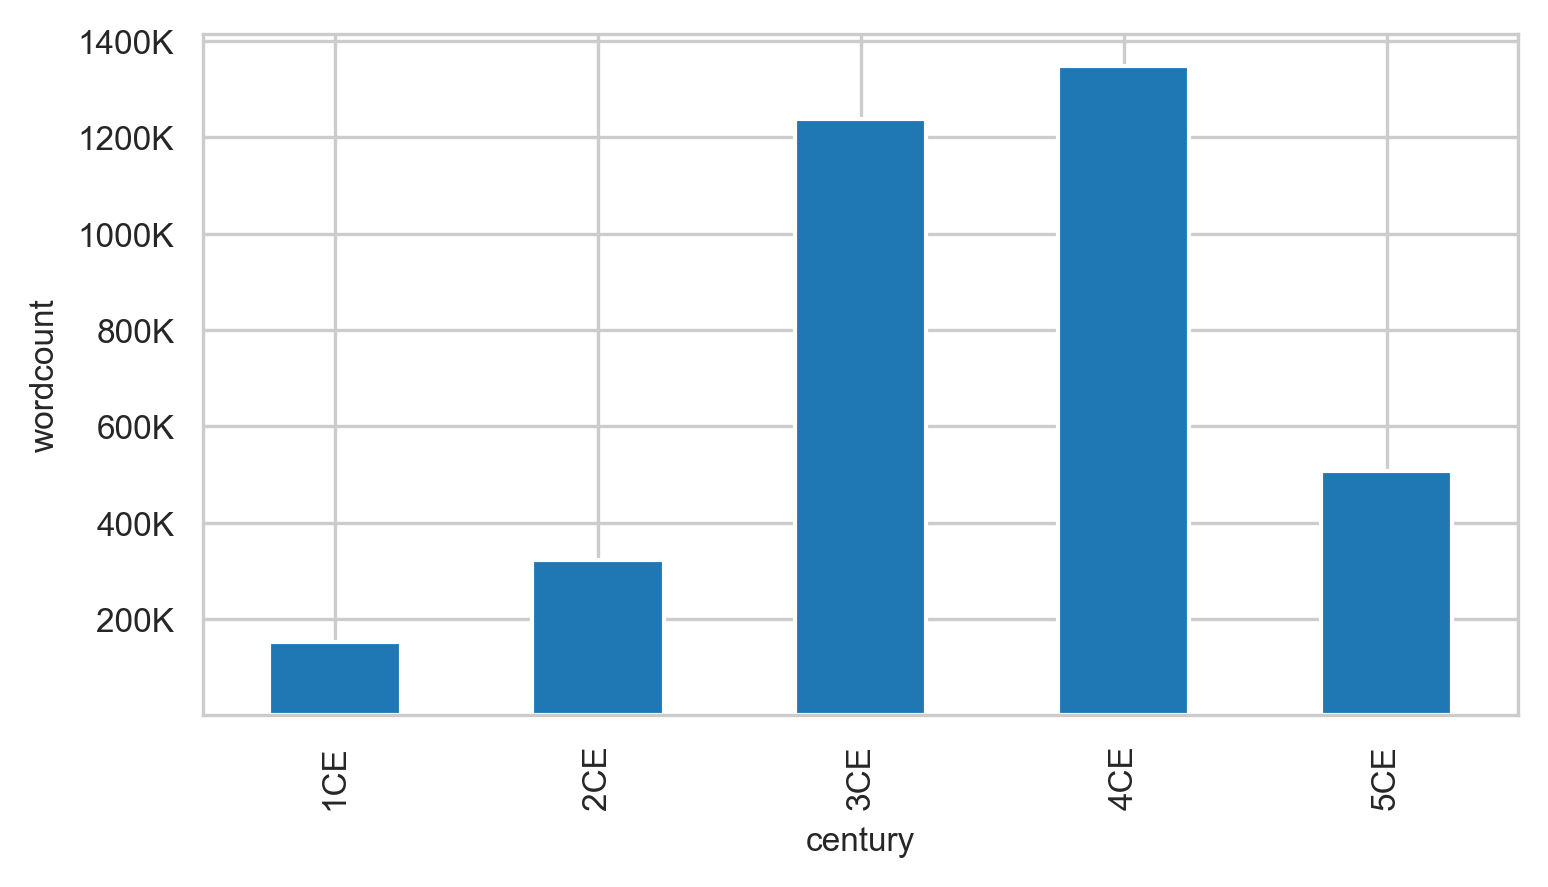

In [38]:
fig, ax = plt.subplots(figsize=[5.2,3], tight_layout=True)
LAGTec_by_date.plot.bar(x="date_avr", y="wordcount", ax=ax, legend=False)
xticklabels = ["1CE", "2CE", "3CE", "4CE", "5CE"]
ax.set_xticklabels(xticklabels)
ax.set_xlabel("century")
xticks=[n for n in range(200000, 1600000, 200000)]
ax.set_yticks(xticks)
xticklabels = [str(n) + "K" for n in range(200, 1600, 200)]
ax.set_yticklabels(xticklabels)
ax.set_ylabel("wordcount")
plt.show()

In [39]:
save_figure(fig, "LAGTec_wordcount_by_century")

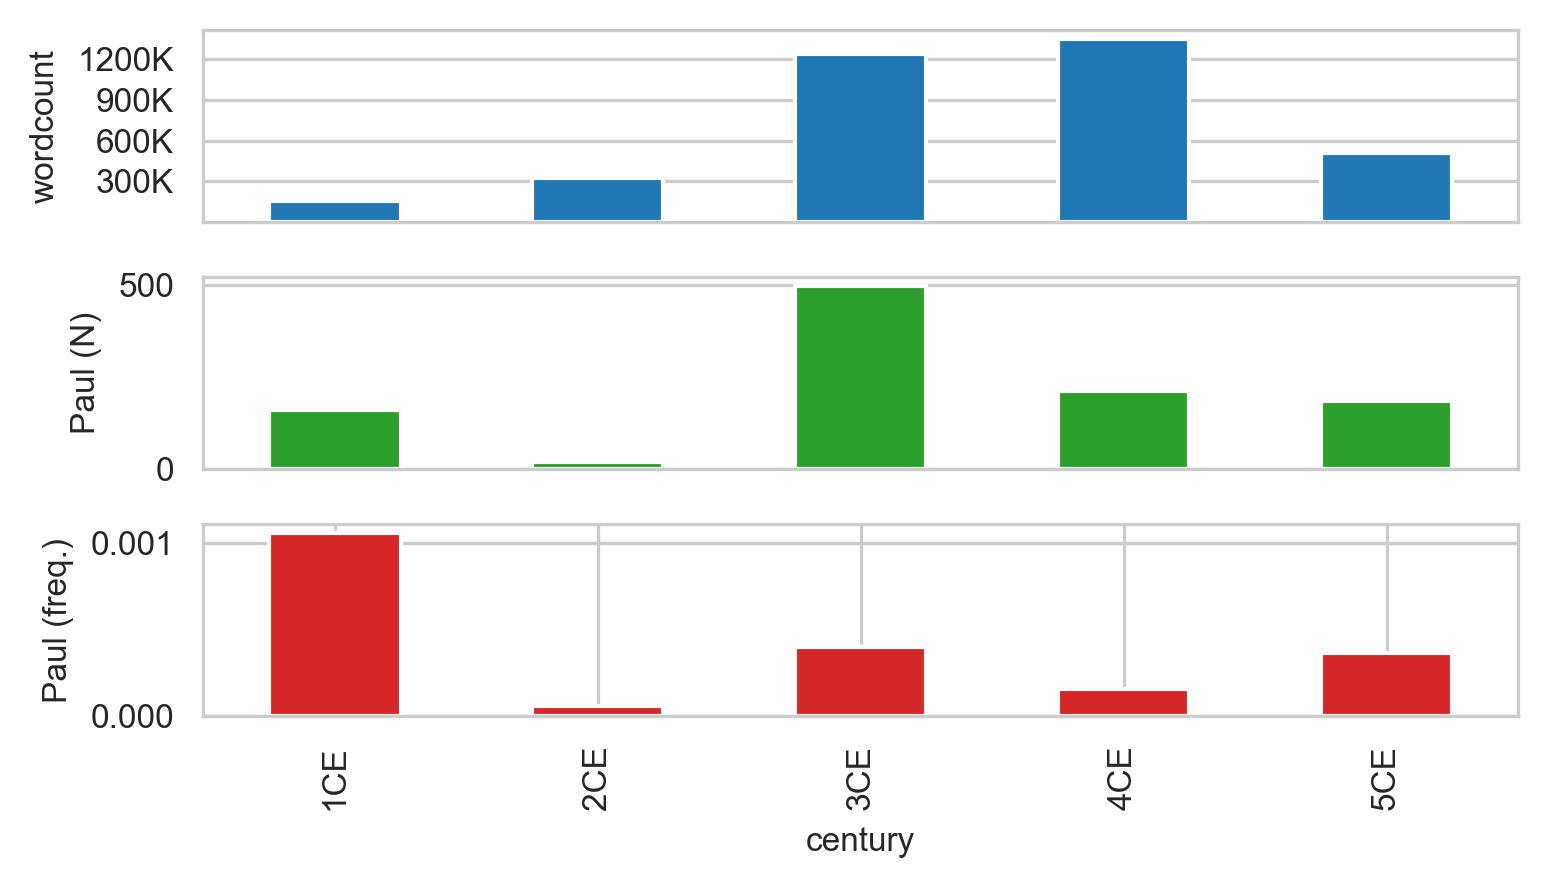

In [40]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=[5.2, 3], tight_layout=True)

# ax1
LAGTec_by_date.plot.bar(x="date_avr", y="wordcount", color="tab:blue", ax=ax1, legend=False)
ax1.set_xticks([])
ax1.set_xlabel("")

yticks=[n for n in range(300000, 1500000, 300000)]
ax1.set_yticks(yticks)
yticklabels = [str(n) + "K" for n in range(300, 1500, 300)]
ax1.set_yticklabels(yticklabels)
ax1.set_ylabel("wordcount")

# ax2
LAGTec_by_date.plot.bar(x="date_avr", y="paul_N", color="tab:green", ax=ax2, legend=False)

ax2.set_xticks([])
ax2.set_xlabel("")

ax2.set_ylabel("Paul (N)")

# ax3
LAGTec_by_date.plot.bar(x="date_avr", y="paul_freq", color="tab:red", ax=ax3, legend=False)

xticklabels = ["1CE", "2CE", "3CE", "4CE", "5CE"]
ax3.set_xticklabels(xticklabels)
ax3.set_xlabel("century")

ax3.set_ylabel("Paul (freq.)")

plt.show()

In [41]:
save_figure(fig, "LAGTec_wordcount+paul_by_century")

# Overview by author

In [158]:
df = LAGTec[(LAGTec["author_id"]!="tlg0031paul")]#  ["sentences_paul_N"].sum()

df_authors = df.groupby("author_id").sum()[["wordcount", "n_sentences", "paul_N","sentences_paul_N", "sentences_apostle_N"]].sort_values("sentences_paul_N", ascending=False)#
author_dict = dict(zip(LAGT_metadata["author_id"],  LAGT_metadata["author"]))
def get_author(x):
    try:
        return author_dict[x]
    except:
        return None

date_dict = dict(zip(LAGT_metadata["author_id"],  LAGT_metadata["date_avr"]))

def get_list_of_works(author_id):
    works = LAGT[LAGT["author_id"]==author_id]["title"].tolist()
    return works


df_authors.reset_index(inplace=True)
df_authors["author"] = df_authors["author_id"].apply(get_author)
df_authors["works"] = df_authors["author_id"].apply(get_list_of_works)
df_authors["works_N"] = df_authors["works"].apply(len)
df_authors["date_avr"] = df_authors["author_id"].apply(lambda x: date_dict[x])
df_authors.set_index("author", inplace=True)
df_authors.reset_index(inplace=True)

df_authors["paul_proportion"] = df_authors["sentences_paul_N"] / df_authors["n_sentences"]
df_authors

,author,author_id,wordcount,n_sentences,paul_N,sentences_paul_N,sentences_apostle_N,works,works_N,date_avr,paul_proportion
0,Origen,tlg2042,931431,110127,471,459,526,"[Contra Celsum, Commentarii in Evangelium Joan...",44,2.5,0.004168
1,Luke-Acts,tlg0031luke,37864,2234,128,125,32,"[Gospel of Luke, Acts]",2,0.5,0.055953
2,Epiphanius,tlg2021,325038,33079,108,102,357,"[Ancoratus, Panarion (Adversus haereses), Anac...",3,3.5,0.003084
3,Socrates of Constantinople,tlg2057,103901,8743,77,76,64,[Historia Ecclesiastica],1,4.5,0.008693
4,Sozomen,tlg2048,112966,7150,63,63,30,[Historia Ecclesiastica],1,4.5,0.008811
5,Athanasius of Alexandria,tlg2035,94010,10789,49,49,90,[De decretis Nicaenae synodi (Chapters 41 and ...,5,3.5,0.004542
6,Theodoret,tlg4089,153333,16094,42,40,36,"[Historia ecclesiastica , Historia Religiosa]",2,4.5,0.002485
7,Basil of Caesarea,tlg2040,144429,11257,25,23,36,"[To Young Men, On How They Might Dervice Profi...",2,3.5,0.002043
8,Clement of Alexandria,tlg0555,235754,14753,18,18,101,"[Protrepticus, Paedagogus, Stromata (Books I-V...",7,2.5,0.001220
9,Eusebius,tlg2018,620546,35220,17,17,199,"[Praeperatio Evangelica, Historia ecclesiastic...",10,3.5,0.000483


In [165]:
df_authors[df_authors["date_avr"]<3]["paul_N"].sum()

656

In [166]:
df_authors[df_authors["date_avr"] > 3]["paul_N"].sum()

397

In [159]:
df_authors.columns

Index(['author', 'author_id', 'wordcount', 'n_sentences', 'paul_N',
       'sentences_paul_N', 'sentences_apostle_N', 'works', 'works_N',
       'date_avr', 'paul_proportion'],
      dtype='object')

In [160]:
columns = ['author', 'author_id', 'works_N', 'works', 'wordcount', 'n_sentences',
        'date_avr','paul_N', 'sentences_apostle_N', 'sentences_paul_N', 'paul_proportion']

In [161]:
set_with_dataframe(paul_results.worksheet("christian_authors_overview"), df_authors[columns])

In [162]:
# save for future usage
LAGTec.to_json("../data/large_files/LAGTec.json")